## 機械学習の単純な例（改）

同じ身長と体重のデータを３次関数でフィッティングさせる。

In [22]:
import numpy as np
import torch
from torchviz import make_dot
import matplotlib.pyplot as plt
import japanize_matplotlib

### 入力データ

In [23]:
data = np.array([
    [166.0, 58.7],
    [176.0, 75.7],
    [171.0, 62.1],
    [173.0, 70.4],
    [169.0, 60.1],
])

x = data[:, 0]
y = data[:, 1]

#### データの正規化

In [24]:
X = (x - x.min()) / (x.max() - x.min())
Y = (y - y.min()) / (y.max() - y.min())

### １エポック分の処理

In [25]:
X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

W = torch.tensor([1.0, 1.0, 1.0], requires_grad=True).float()
B = torch.tensor(1.0, requires_grad=True).float()


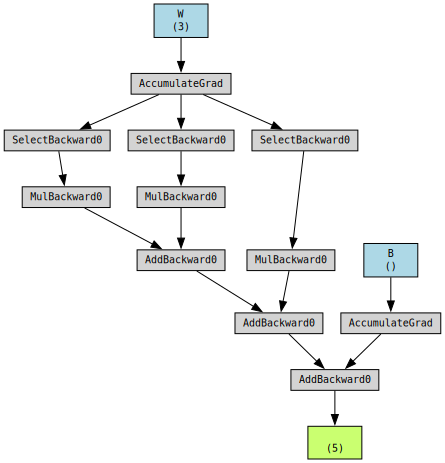

In [26]:
def pred(X, W, B):
    return W[0] * X ** 3 + W[1] * X ** 2 + W[2] * X + B

Yp = pred(X, W, B)

params = {'W': W, 'B': B}
g = make_dot(Yp, params=params)

display(g)

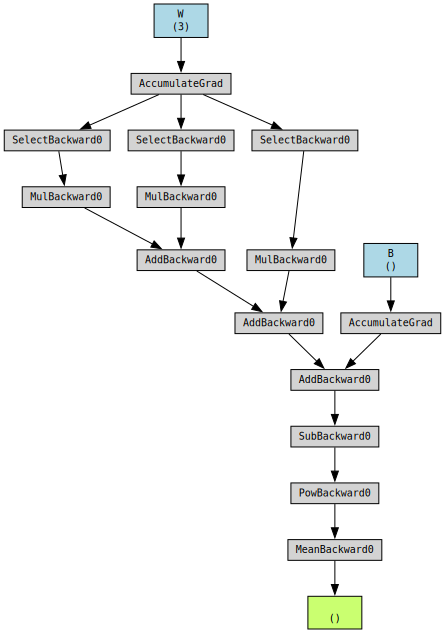

In [27]:
def mse(Yp, Y):
    loss = ((Yp - Y) ** 2).mean()
    return loss

loss = mse(Yp, Y)

g = make_dot(loss, params=params)

display(g)

In [28]:
# これによって勾配を計算する
loss.backward()

In [29]:
lr = 0.001

# 手動で勾配から計算する、いちばん原始的な方法
with torch.no_grad():
    W -= lr * W.grad
    B -= lr * B.grad
    W.grad.zero_()
    B.grad.zero_()


### 複数回、繰り返す

In [30]:
W = torch.tensor([1.0, 1.0, 1.0], requires_grad=True).float()
B = torch.tensor(1.0, requires_grad=True).float()

num_epochs = 500

lr = 0.001

history = np.zeros((0, 2))

In [31]:
for epoch in range(num_epochs):
    Yp = pred(X, W, B)
    loss = mse(Yp, Y)
    loss.backward()
    ##### この過程をoptimizerを使って自動化することができる
    with torch.no_grad():
        W -= lr * W.grad
        B -= lr * B.grad
        W.grad.zero_()
        B.grad.zero_()
    #####
    if epoch % 10 == 0:
        item = [epoch, loss.item()]
        history = np.vstack((history, item)) # historyにitemを列方向（axis=0）へ追加してゆく
        if epoch % 100 == 0:
            print(f'epoch: {epoch} / loss: {loss:.4f} / (W, B) = ({W.data.numpy()}, {B.item():.2f})')

print(f'W = {W.data.numpy()}')
print(f'B = {B.data.numpy()}')

print(f'init: loss = {history[0, 1]:.4f}')
print(f'last: loss = {history[-1, 1]:.4f}')

epoch: 0 / loss: 3.5980 / (W, B) = ([0.9984487 0.9982229 0.9977883], 1.00)
epoch: 100 / loss: 1.8987 / (W, B) = ([0.8653549 0.845991  0.8086742], 0.69)
epoch: 200 / loss: 1.0051 / (W, B) = ([0.7676719  0.7347012  0.67104846], 0.48)
epoch: 300 / loss: 0.5351 / (W, B) = ([0.69571215 0.6531386  0.57078224], 0.32)
epoch: 400 / loss: 0.2878 / (W, B) = ([0.64244884 0.5931705  0.49763012], 0.21)
W = [0.6031275  0.54927826 0.44461897]
B = 0.12876220047473907
init: loss = 3.5980
last: loss = 0.1672


(0.0, 500.0)

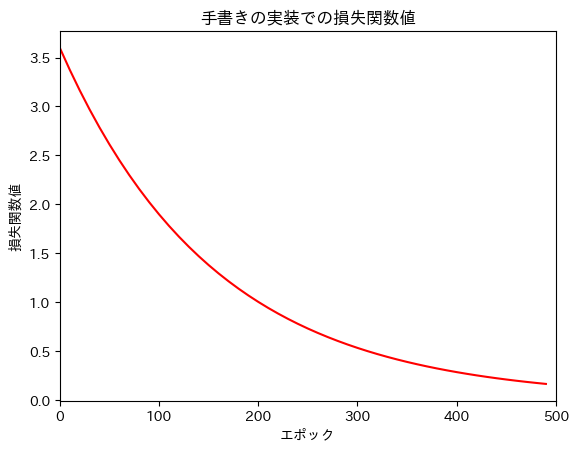

In [32]:
plt.title('手書きの実装での損失関数値')
plt.plot(history[:, 0], history[:, 1], 'r')
plt.xlabel('エポック')
plt.ylabel('損失関数値')
plt.xlim(0, num_epochs)


Text(0, 0.5, '$Y = (y - y_{min}) / (y_{max} - y_{min})$')

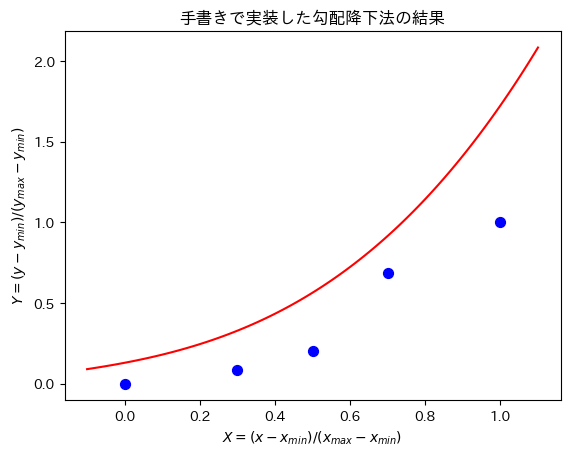

In [33]:
xx = np.arange(X.min() - 0.1, X.max() + 0.1, 0.01)
yy = W[0].item() * xx ** 3 + W[1].item() * xx ** 2 + W[2].item() * xx + B.item()

plt.title('手書きで実装した勾配降下法の結果')
plt.scatter(X, Y, c='b', s=50)
plt.plot(xx, yy, c='red')
plt.xlabel('$X = (x - x_{min}) / (x_{max} - x_{min})$')
plt.ylabel('$Y = (y - y_{min}) / (y_{max} - y_{min})$')



### パラメタ更新過程にSDGを利用

In [34]:
W2 = torch.tensor([1.0, 1.0, 1.0], requires_grad=True).float()
B2 = torch.tensor(1.0, requires_grad=True).float()

In [35]:
import torch.optim as optim

optimizer = optim.SGD([W2, B2], lr=lr, momentum=0.9)
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
history2 = np.zeros((0, 2))

for epoch in range(num_epochs):
    Yp = pred(X, W2, B2)
    loss = mse(Yp, Y)
    loss.backward()
    ##### ここがoptimizerを使った部分
    optimizer.step()
    optimizer.zero_grad()
    #####
    if epoch % 10 == 0:
        item = [epoch, loss.item()]
        history2 = np.vstack((history2, item))
        if epoch % 100 == 0:
            print(f'epoch: {epoch} / loss: {loss:.4f} / (W2_0, W2_1, W2_2, B2) = ({W2[0].item():.2f}, {W2[1].item():.2f}, {W2[2].item():.2f}, {B2.item():.2f})')


epoch: 0 / loss: 3.5980 / (W2_0, W2_1, W2_2, B2) = (1.00, 1.00, 1.00, 1.00)
epoch: 100 / loss: 0.0120 / (W2_0, W2_1, W2_2, B2) = (0.49, 0.43, 0.30, -0.08)
epoch: 200 / loss: 0.0097 / (W2_0, W2_1, W2_2, B2) = (0.46, 0.41, 0.29, -0.05)
epoch: 300 / loss: 0.0089 / (W2_0, W2_1, W2_2, B2) = (0.44, 0.39, 0.29, -0.03)
epoch: 400 / loss: 0.0085 / (W2_0, W2_1, W2_2, B2) = (0.43, 0.39, 0.28, -0.02)


In [36]:
print(f'W2 = {W2.data.numpy()}')
print(f'B2 = {B2.data.numpy()}')

print(f'init: loss = {history2[0, 1]:.4f}')
print(f'last: loss = {history2[-1, 1]:.4f}')

W2 = [0.41935384 0.38204655 0.28433615]
B2 = -0.015291444957256317
init: loss = 3.5980
last: loss = 0.0084


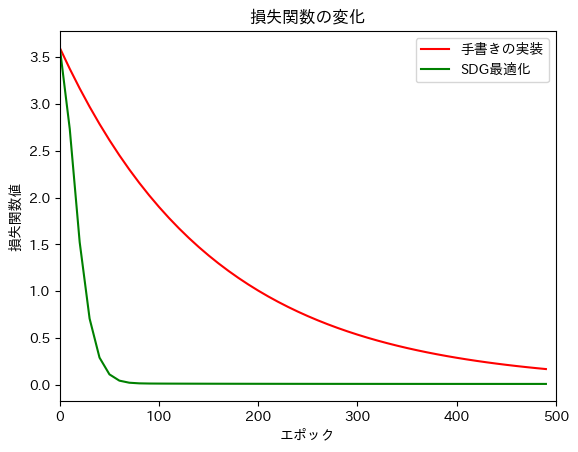

In [37]:
plt.title('損失関数の変化')
plt.xlabel('エポック')
plt.ylabel('損失関数値')
plt.plot(history[:, 0], history[:, 1], 'r', label='手書きの実装')
plt.plot(history2[:, 0], history2[:, 1], 'g', label='SDG最適化')
plt.xlim(0, num_epochs)
plt.legend()

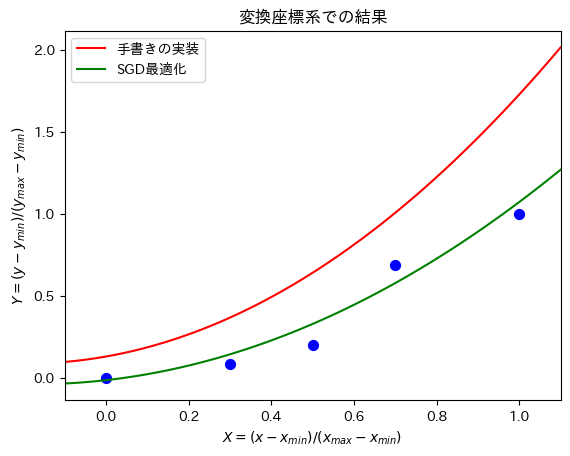

In [38]:
xx = np.arange(X.min() - 0.1, X.max() + 0.1, 0.01)
y1 = W[0].item() * xx ** 2 + W[1].item() * xx ** 2 + W[2].item() * xx + B.item()
y2 = W2[0].item() * xx ** 2 + W2[1].item() * xx ** 2 + W2[2].item() * xx + B2.item()
#y1 = pred(xx, W, B)
#y2 = pred(xx, W2, B2)

plt.title('変換座標系での結果')
plt.scatter(X, Y, c='blue', s=50)
plt.plot(xx, y1, c='red', label='手書きの実装')
plt.plot(xx, y2, c='green', label='SGD最適化')
plt.xlim(xx.min(), xx.max())
plt.xlabel('$X = (x - x_{min}) / (x_{max} - x_{min})$')
plt.ylabel('$Y = (y - y_{min}) / (y_{max} - y_{min})$')
plt.legend()


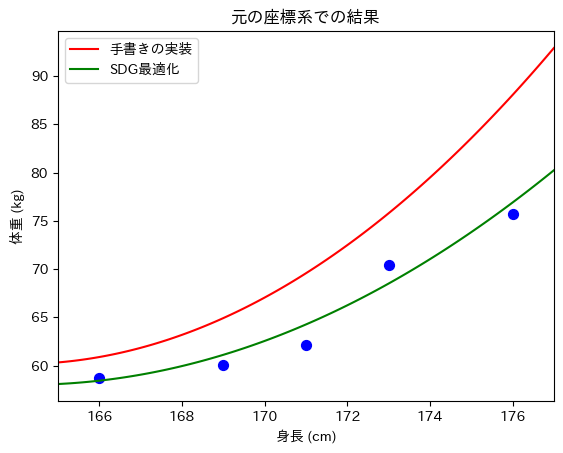

In [39]:
xx = xx * (x.max() - x.min()) + x.min()
y1 = y1 * (y.max() - y.min()) + y.min()
y2 = y2 * (y.max() - y.min()) + y.min()

plt.title('元の座標系での結果')
plt.scatter(x, y, c='blue', s=50)
plt.plot(xx, y1, c='red', label='手書きの実装')
plt.plot(xx, y2, c='green', label='SDG最適化')
plt.xlim(xx.min(), xx.max())
plt.xlabel('身長 (cm)')
plt.ylabel('体重 (kg)')
plt.legend()
